In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.add import UnaryAdd_int
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np
global perfect_result_RMSE
global perfect_result_MAE
import copy
import pandas as pd
from pandas import Series, DataFrame
import math

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "LFSR"

In [47]:
global perfect_result_RMSE
global perfect_result_MAE

In [48]:
def base_line():
    modes = ["unipolar"]
    rng="Sobol"
    row=128
    col=10000
    
    global perfect_result_RMSE
    global perfect_result_MAE
    
    scaled = [True]
    result_pe = []
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    bw = [4,5,6,7,8]
    
    perfect_result_RMSE = dict()
    perfect_result_MAE = dict()
    
    for bitwidth in bw:
        for mode in modes:
            for scale in scaled:
                run_time = 0
                acc_dim = 0
                result_pe_cycle = []
                uadd = UnaryAdd_int(mode=mode, scaled=scale, acc_dim=acc_dim, 
                                    back=False,back_up=None).to(device)

                if mode is "unipolar":
                    iVec = torch.rand(row, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
                elif mode is "bipolar":
                    iVec = torch.rand(row, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

                oVec = torch.sum(iVec, acc_dim).to(device)

                iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)

                iVecRNG = RNG(bitwidth, 1, rng, rtype)().to(device)
                iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

                iVecPE = ProgressiveError(iVec, scale=1, mode=mode).to(device)

                if scale is True:
                    if acc_dim == 0:
                        oVecPE = ProgressiveError(oVec, scale=row, mode=mode).to(device)
                    elif acc_dim ==1:
                        oVecPE = ProgressiveError(oVec, scale=col, mode=mode).to(device)
                else:
                    oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)

                with torch.no_grad():
                    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                    for i in range(2**bitwidth):
                        iBS = iVecBS(idx + i)
                        iVecPE.Monitor(iBS)

                        start_time = time.time()
                        oVecU = uadd(iBS)
                        run_time = time.time() - start_time + run_time

                        oVecPE.Monitor(oVecU)
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/col).item())
    #                 print("mode:",str(mode))
                    result_pe = oVecPE()[1].cpu().numpy()
    #                 print("base RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
                    perfect_result_RMSE[bitwidth] = math.sqrt(sum(result_pe**2)/len(result_pe))
    #                 print("base MAE: {:1.4}".format(np.mean(np.abs(result_pe))))
                    perfect_result_MAE[bitwidth] = np.mean(np.abs(result_pe))


In [49]:
base_line()

In [50]:
def add_int_save_counter(bw):

    modes = ["unipolar"]
    rng="Sobol"
    row=128
    col=10000

    scaled = [True]
    result_pe = []
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    bitwidth = bw
    
    time_list=[]
    rmse_list=[]
    mae_list=[]
    mae_per_list=[]
    rmse_per_list=[]
    
    for power_off in range(0,2**bitwidth):

        for mode in modes:
            for scale in scaled:
                run_time = 0
                acc_dim = 0
                result_pe_cycle = []
                uadd = UnaryAdd_int(mode=mode, scaled=scale, acc_dim=acc_dim, back=False,back_up=None).to(device)

                if mode is "unipolar":
                    iVec = torch.rand(row, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
                elif mode is "bipolar":
                    iVec = torch.rand(row, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

                oVec = torch.sum(iVec, acc_dim).to(device)

                iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)

                iVecRNG = RNG(bitwidth, 1, rng, rtype)().to(device)
                iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

                iVecPE = ProgressiveError(iVec, scale=1, mode=mode).to(device)
                error_print = []

                if scale is True:
                    if acc_dim == 0:
                        oVecPE = ProgressiveError(oVec, scale=row, mode=mode).to(device)
                    elif acc_dim ==1:
                        oVecPE = ProgressiveError(oVec, scale=col, mode=mode).to(device)
                else:
                    oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)

                with torch.no_grad():
                    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                    for i in range(0,power_off):
                        iBS = iVecBS(idx + i)
                        iVecPE.Monitor(iBS)

                        start_time = time.time()
                        oVecU = uadd(iBS)
                        run_time = time.time() - start_time + run_time

                        oVecPE.Monitor(oVecU)
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/col).item())
                        result_pe = oVecPE()[1].cpu().numpy()
                        error_print.append(abs(np.mean(np.abs(result_pe))))
#                         print(oVecPE()[1].cpu().numpy())
#                         error_print.append(oVecPE()[1].cpu().numpy())
                    save = copy.deepcopy(uadd.accumulator)
                    uadd = UnaryAdd_int(mode=mode, scaled=scale, acc_dim=acc_dim, back=True,back_up=save).to(device)
                    for i in range(power_off,2**bitwidth):
                        iBS = iVecBS(idx + i)
                        iVecPE.Monitor(iBS)

                        start_time = time.time()
                        oVecU = uadd(iBS)
                        run_time = time.time() - start_time + run_time

                        oVecPE.Monitor(oVecU)
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/col).item())
                        result_pe = oVecPE()[1].cpu().numpy()
                        error_print.append(abs(np.mean(np.abs(result_pe))))
#                         print(oVecPE()[1].cpu().numpy())
                        ##error_print.append(oVecPE()[1].cpu().numpy())
                    ax = Series(error_print).plot.line(legend=False,label=power_off)
                    ax.set_ylim(0)
                    ax.set_title(f"save cnter, bitwidth: {bw}")
                    result_pe = oVecPE()[1].cpu().numpy()
                    time_list.append(time.time() - start_time)
                    rmse_list.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                    mae_list.append(np.mean(np.abs(result_pe)))
#                     print(np.mean(np.abs(result_pe)))
                    mae_per_list.append(abs(np.mean(np.abs(result_pe))-perfect_result_MAE[bw])/perfect_result_MAE[bw])
                    rmse_per_list.append(abs(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE[bw])/perfect_result_RMSE[bw])

    print("Mode:",str(mode))
    print("--- %s Average seconds ---" % (sum(time_list)/len(time_list)))         
    print("Avg RMSE", sum(rmse_list)/len(rmse_list))
    print("Avg MAE: {:1.4}".format(sum(mae_list)/len(mae_list)))
    print("Avg RMSE_error from perfect: {:.2%}".format(sum(rmse_per_list)/len(rmse_per_list)))
    print("Avg MAE_error from perfect: {:.2%}".format(sum(mae_per_list)/len(mae_per_list)))

In [51]:
def add_int_not_save_counter(bw):

    modes = ["unipolar"]
    rng="Sobol"
    row=128
    col=10000

    scaled = [True]
    result_pe = []
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    bitwidth = bw
    
    time_list=[]
    rmse_list=[]
    mae_list=[]
    mae_per_list=[]
    rmse_per_list=[]
    for power_off in range(0,2**bitwidth):

        for mode in modes:
            for scale in scaled:
                run_time = 0
                acc_dim = 0
                result_pe_cycle = []
                uadd = UnaryAdd_int(mode=mode, scaled=scale, acc_dim=acc_dim, back=False,back_up=None).to(device)

                if mode is "unipolar":
                    iVec = torch.rand(row, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
                elif mode is "bipolar":
                    iVec = torch.rand(row, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

                oVec = torch.sum(iVec, acc_dim).to(device)

                iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)

                iVecRNG = RNG(bitwidth, 1, rng, rtype)().to(device)
                iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

                iVecPE = ProgressiveError(iVec, scale=1, mode=mode).to(device)
                error_print = []

                if scale is True:
                    if acc_dim == 0:
                        oVecPE = ProgressiveError(oVec, scale=row, mode=mode).to(device)
                    elif acc_dim ==1:
                        oVecPE = ProgressiveError(oVec, scale=col, mode=mode).to(device)
                else:
                    oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)

                with torch.no_grad():
                    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                    for i in range(0,power_off):
                        iBS = iVecBS(idx + i)
                        iVecPE.Monitor(iBS)

                        start_time = time.time()
                        oVecU = uadd(iBS)
                        run_time = time.time() - start_time + run_time

                        oVecPE.Monitor(oVecU)
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/col).item())
                        result_pe = oVecPE()[1].cpu().numpy()
                        error_print.append(abs(np.mean(np.abs(result_pe))))
#                         print(oVecPE()[1].cpu().numpy())
#                         error_print.append(oVecPE()[1].cpu().numpy())
                    uadd = UnaryAdd_int(mode=mode, scaled=scale, acc_dim=acc_dim, back=False,back_up=None).to(device)
                    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                    for i in range(power_off,2**bitwidth):
                        iBS = iVecBS(idx + i)
                        iVecPE.Monitor(iBS)
                        
                        start_time = time.time()
                        oVecU = uadd(iBS)
                        run_time = time.time() - start_time + run_time

                        oVecPE.Monitor(oVecU)
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/col).item())
                        result_pe = oVecPE()[1].cpu().numpy()
                        error_print.append(abs(np.mean(np.abs(result_pe))))
#                         print(oVecPE()[1].cpu().numpy())
                        ##error_print.append(oVecPE()[1].cpu().numpy())
                    ax = Series(error_print).plot.line(legend=False,label=power_off)
                    ax.set_ylim(0)
                    ax.set_title(f"save cnter, bitwidth: {bw}")
                    result_pe = oVecPE()[1].cpu().numpy()
                    time_list.append(time.time() - start_time)
                    rmse_list.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
#                     print(np.mean(np.abs(result_pe)))
                    mae_list.append(np.mean(np.abs(result_pe)))
                    mae_per_list.append(abs(np.mean(np.abs(result_pe))-perfect_result_MAE[bw])/perfect_result_MAE[bw])
                    rmse_per_list.append(abs(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE[bw])/perfect_result_RMSE[bw])

    print("Mode:",str(mode))
    print("--- %s Average seconds ---" % (sum(time_list)/len(time_list)))         
    print("Avg RMSE", sum(rmse_list)/len(rmse_list))
    print("Avg MAE: {:1.4}".format(sum(mae_list)/len(mae_list)))
    print("Avg RMSE_error from perfect: {:.2%}".format(sum(rmse_per_list)/len(rmse_per_list)))
    print("Avg MAE_error from perfect: {:.2%}".format(sum(mae_per_list)/len(mae_per_list)))

Mode: unipolar
--- 0.007342547178268433 Average seconds ---
Avg RMSE 0.009188358375988376
Avg MAE: 0.008003
Avg RMSE_error from perfect: 0.68%
Avg MAE_error from perfect: 0.80%


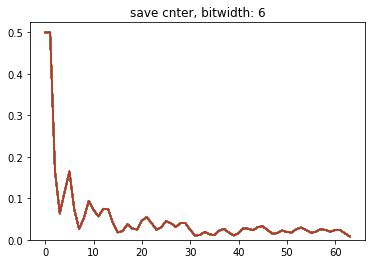

In [52]:
add_int_save_counter(6)

Mode: unipolar
--- 0.007560506463050842 Average seconds ---
Avg RMSE 0.01684177106581587
Avg MAE: 0.01569
Avg RMSE_error from perfect: 84.53%
Avg MAE_error from perfect: 97.53%


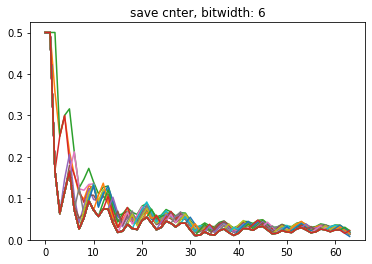

In [53]:
add_int_not_save_counter(6)

Mode: unipolar
--- 0.007280774414539337 Average seconds ---
Avg RMSE 0.018788629958960027
Avg MAE: 0.01647
Avg RMSE_error from perfect: 0.60%
Avg MAE_error from perfect: 0.76%


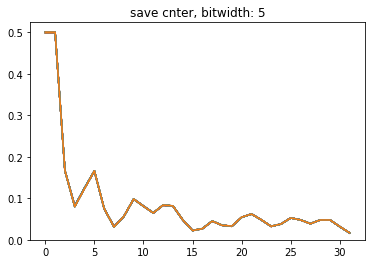

In [54]:
add_int_save_counter(5)

Mode: unipolar
--- 0.007775440812110901 Average seconds ---
Avg RMSE 0.03385524719135173
Avg MAE: 0.03182
Avg RMSE_error from perfect: 81.21%
Avg MAE_error from perfect: 94.61%


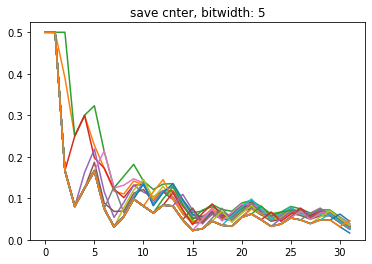

In [55]:
add_int_not_save_counter(5)

Mode: unipolar
--- 0.013956636190414429 Average seconds ---
Avg RMSE 0.03964788684644814
Avg MAE: 0.0351
Avg RMSE_error from perfect: 0.40%
Avg MAE_error from perfect: 0.54%


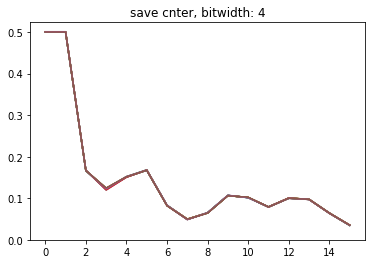

In [56]:
add_int_save_counter(4)

Mode: unipolar
--- 0.008997619152069092 Average seconds ---
Avg RMSE 0.0693712252529279
Avg MAE: 0.06522
Avg RMSE_error from perfect: 74.48%
Avg MAE_error from perfect: 85.26%


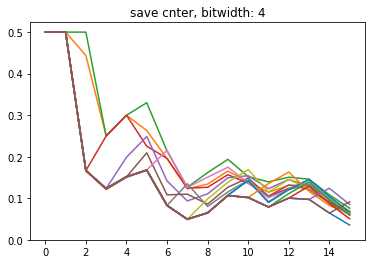

In [57]:
add_int_not_save_counter(4)

mode: unipolar
--- 0.004003047943115234 base seconds ---
base RMSE 0.004505622717004442
base MAE: 0.003904
Mode: unipolar
--- 0.012091528624296188 Average seconds ---
Avg RMSE 0.008384529036111022
Avg MAE: 0.007788
Avg RMSE_error from perfect: 86.09%
Avg MAE_error from perfect: 99.47%


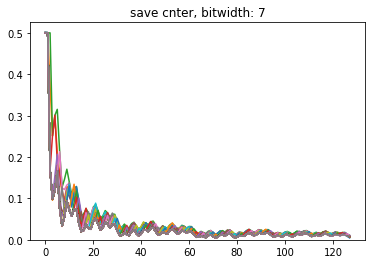

In [44]:
add_int_not_save_counter(7)

mode: unipolar
--- 0.0010001659393310547 base seconds ---
base RMSE 0.004538507117339178
base MAE: 0.003939
Mode: unipolar
--- 0.00913672149181366 Average seconds ---
Avg RMSE 0.004538273426131239
Avg MAE: 0.003938
Avg RMSE_error from perfect: 0.33%
Avg MAE_error from perfect: 0.42%


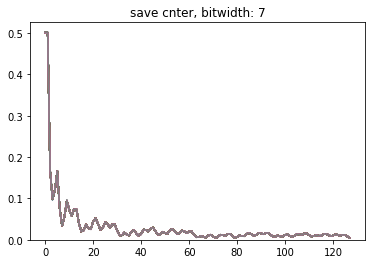

In [45]:
add_int_save_counter(7)

mode: unipolar
--- 0.0010004043579101562 base seconds ---
base RMSE 0.0022569020656535758
base MAE: 0.001957
Mode: unipolar
--- 0.009484481066465378 Average seconds ---
Avg RMSE 0.0022558747624255686
Avg MAE: 0.001954
Avg RMSE_error from perfect: 0.43%
Avg MAE_error from perfect: 0.57%


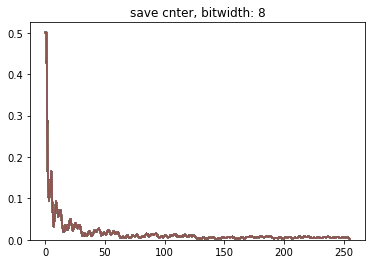

In [46]:
add_int_save_counter(8)

mode: unipolar
--- 0.0010008811950683594 base seconds ---
base RMSE 0.002258914121900517
base MAE: 0.001952
Mode: unipolar
--- 0.009375118650496006 Average seconds ---
Avg RMSE 0.004187764060084744
Avg MAE: 0.003879
Avg RMSE_error from perfect: 85.39%
Avg MAE_error from perfect: 98.75%


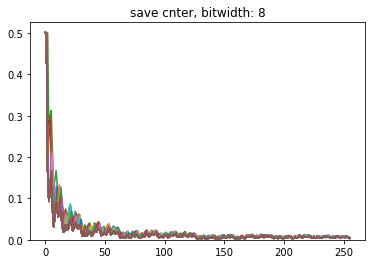

In [47]:
add_int_not_save_counter(8)

In [58]:
import matplotlib.pyplot as plt
def add_int_not_save_counter_multi(bw,n):
    add_test(bw)
    modes = ["unipolar"]
    rng="Sobol"
    row=128
    col=10000

    scaled = [True]
    result_pe = []
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    bitwidth = bw
    global perfect_result_RMSE
    global perfect_result_MAE
    
    time_list=[]
    rmse_list=[]
    mae_list=[]
    mae_per_list=[]
    rmse_per_list=[]
    off_cycle = []

    for i in range(0+math.floor(2**bw/n),2**bw, math.floor(2**bw/n)):
        
        off_cycle.append(i)
    
    for mode in modes:
        for scale in scaled:
            run_time = 0
            acc_dim = 0
            result_pe_cycle = []
            uadd = UnaryAdd_int(mode=mode, scaled=scale, acc_dim=acc_dim, back=False,back_up=None).to(device)

            if mode is "unipolar":
                iVec = torch.rand(row, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
            elif mode is "bipolar":
                iVec = torch.rand(row, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

            oVec = torch.sum(iVec, acc_dim).to(device)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)

            iVecRNG = RNG(bitwidth, 1, rng, rtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

            iVecPE = ProgressiveError(iVec, scale=1, mode=mode).to(device)
            error_print = []

            if scale is True:
                if acc_dim == 0:
                    oVecPE = ProgressiveError(oVec, scale=row, mode=mode).to(device)
                elif acc_dim ==1:
                    oVecPE = ProgressiveError(oVec, scale=col, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)

            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                for i in range(0,2**bitwidth):
                    if i in off_cycle:
                        uadd = UnaryAdd_int(mode=mode, scaled=scale, acc_dim=acc_dim, back=False,back_up=None).to(device)
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    start_time = time.time()
                    oVecU = uadd(iBS)
                    run_time = time.time() - start_time + run_time

                    oVecPE.Monitor(oVecU)
                    result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/col).item())
                    result_pe = oVecPE()[1].cpu().numpy()
                    error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                    
#                     for i in range(power_off,power_off+4):
#                         print(d + i)
#                         iBS = iVecBS(idx + i)
#                         iVecPE.Monitor(iBS)

#                         start_time = time.time()
#                         oVecU = uadd(iBS)
#                         run_time = time.time() - start_time + run_time

#                         oVecPE.Monitor(oVecU)
#                         result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/col).item())
#                         result_pe = oVecPE()[1].cpu().numpy()
#                         error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                ax = Series(error_print).plot.line(legend=False)
                ax.set_ylim(0)
                ax.set_title(f"save cnter, bitwidth: {bw}")
                result_pe = oVecPE()[1].cpu().numpy()
                time_list.append(time.time() - start_time)
                rmse_list.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                mae_list.append(np.mean(np.abs(result_pe)))
                mae_per_list.append(abs(np.mean(np.abs(result_pe))-perfect_result_MAE)/perfect_result_MAE)
                rmse_per_list.append(abs(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE)/perfect_result_RMSE)
                    
#     print("mode:",str(mode))
#     print("--- %s base seconds ---" % (time.time() - start_time))
#     result_pe = oVecPE()[1].cpu().numpy()
#     print("base RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
#     perfect_result_RMSE = math.sqrt(sum(result_pe**2)/len(result_pe))
#     print("base MAE: {:1.4}".format(np.mean(np.abs(result_pe))))
#     perfect_result_MAE = np.mean(np.abs(result_pe))
#     fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
#     plt.title("Histogram for final output error")
#     plt.show()
    print("Mode:",str(mode))
    print("--- %s Average seconds ---" % (sum(time_list)/len(time_list)))         
    print("Avg RMSE", sum(rmse_list)/len(rmse_list))
    print("Avg MAE: {:1.4}".format(sum(mae_list)/len(mae_list)))
    print("Avg RMSE_error from perfect: {:.2%}".format(sum(rmse_per_list)/len(rmse_per_list)))
    print("Avg MAE_error from perfect: {:.2%}".format(sum(mae_per_list)/len(mae_per_list)))

mode: unipolar
--- 0.0020017623901367188 base seconds ---
base RMSE 0.03974114734510056
base MAE: 0.03522
1
5
10
15
Mode: unipolar
--- 0.015625715255737305 Average seconds ---
Avg RMSE 0.14234463202562297
Avg MAE: 0.141
Avg RMSE_error from perfect: 258.18%
Avg MAE_error from perfect: 300.27%


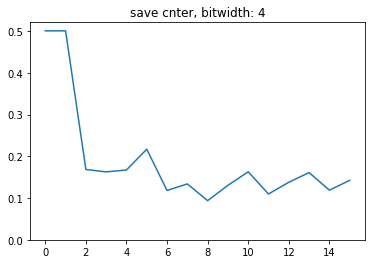

In [54]:
add_int_not_save_counter_multi(4,3)

mode: unipolar
--- 0.0010006427764892578 base seconds ---
base RMSE 0.03976549039866632
base MAE: 0.03525
Mode: unipolar
--- 0.010405093431472778 Average seconds ---
Avg RMSE 0.06939820473301454
Avg MAE: 0.06525
Avg RMSE_error from perfect: 74.57%
Avg MAE_error from perfect: 85.17%


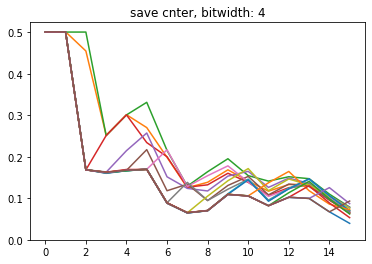

In [31]:
add_int_not_save_counter(4)

mode: unipolar
--- 0.0 base seconds ---
base RMSE 0.03971861783297539
base MAE: 0.03511
1
4
8
12
Mode: unipolar
--- 0.031249046325683594 Average seconds ---
Avg RMSE 0.1137623807436401
Avg MAE: 0.1089
Avg RMSE_error from perfect: 186.42%
Avg MAE_error from perfect: 210.05%


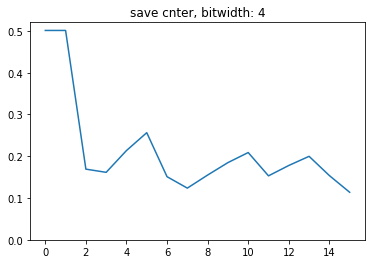

In [32]:
add_int_not_save_counter_multi(4,4)

mode: unipolar
--- 0.0 base seconds ---
base RMSE 0.039635196974250324
base MAE: 0.03507
0
3
6
9
12
15
Mode: unipolar
--- 0.031252145767211914 Average seconds ---
Avg RMSE 0.20248770046557424
Avg MAE: 0.2009
Avg RMSE_error from perfect: 410.88%
Avg MAE_error from perfect: 472.75%


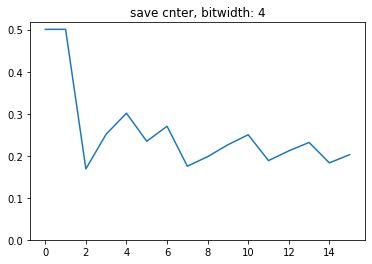

In [33]:
add_int_not_save_counter_multi(4,5)

mode: unipolar
--- 0.0 base seconds ---
base RMSE 0.03972512241630346
base MAE: 0.0352
0
2
4
6
8
10
12
14
Mode: unipolar
--- 0.015626192092895508 Average seconds ---
Avg RMSE 0.25202020042684525
Avg MAE: 0.2508
Avg RMSE_error from perfect: 534.41%
Avg MAE_error from perfect: 612.45%


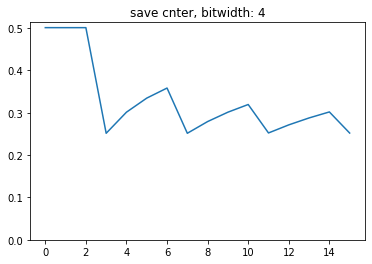

In [34]:
add_int_not_save_counter_multi(4,6)

mode: unipolar
--- 0.0 base seconds ---
base RMSE 0.0395944284984619
base MAE: 0.03491
0
2
4
6
8
10
12
14
Mode: unipolar
--- 0.015626192092895508 Average seconds ---
Avg RMSE 0.2516474595277228
Avg MAE: 0.2504
Avg RMSE_error from perfect: 535.56%
Avg MAE_error from perfect: 617.30%


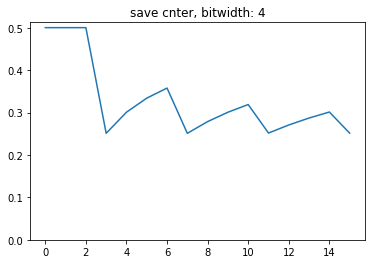

In [35]:
add_int_not_save_counter_multi(4,7)

In [59]:
import matplotlib.pyplot as plt
def add_int_save_counter_multi(bw,n):
    add_test(bw)
    modes = ["unipolar"]
    rng="Sobol"
    row=128
    col=10000

    scaled = [True]
    result_pe = []
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    bitwidth = bw
    global perfect_result_RMSE
    global perfect_result_MAE
    
    time_list=[]
    rmse_list=[]
    mae_list=[]
    mae_per_list=[]
    rmse_per_list=[]
    off_cycle = []
    
    for i in range(0+math.floor(2**bw/n),2**bw, math.floor(2**bw/n)):
        off_cycle.append(i)
    

    for mode in modes:
        for scale in scaled:
            run_time = 0
            acc_dim = 0
            result_pe_cycle = []
            uadd = UnaryAdd_int(mode=mode, scaled=scale, acc_dim=acc_dim, back=False,back_up=None).to(device)

            if mode is "unipolar":
                iVec = torch.rand(row, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
            elif mode is "bipolar":
                iVec = torch.rand(row, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

            oVec = torch.sum(iVec, acc_dim).to(device)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)

            iVecRNG = RNG(bitwidth, 1, rng, rtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

            iVecPE = ProgressiveError(iVec, scale=1, mode=mode).to(device)
            error_print = []

            if scale is True:
                if acc_dim == 0:
                    oVecPE = ProgressiveError(oVec, scale=row, mode=mode).to(device)
                elif acc_dim ==1:
                    oVecPE = ProgressiveError(oVec, scale=col, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)

            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                for i in range(0,2**bitwidth):
                    if i in off_cycle:
                        save = copy.deepcopy(uadd.accumulator)
                        uadd = UnaryAdd_int(mode=mode, scaled=scale, acc_dim=acc_dim, back=True,back_up=save).to(device)
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    start_time = time.time()
                    oVecU = uadd(iBS)
                    run_time = time.time() - start_time + run_time

                    oVecPE.Monitor(oVecU)
                    result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/col).item())
                    result_pe = oVecPE()[1].cpu().numpy()
                    error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))

                ax = Series(error_print).plot.line(legend=False)
                ax.set_ylim(0)
                ax.set_title(f"save cnter, bitwidth: {bw}")
                result_pe = oVecPE()[1].cpu().numpy()
                time_list.append(time.time() - start_time)
                rmse_list.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                mae_list.append(np.mean(np.abs(result_pe)))
                mae_per_list.append(abs(np.mean(np.abs(result_pe))-perfect_result_MAE)/perfect_result_MAE)
                rmse_per_list.append(abs(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE)/perfect_result_RMSE)
                    
    print("Mode:",str(mode))
    print("--- %s Average seconds ---" % (sum(time_list)/len(time_list)))         
    print("Avg RMSE", sum(rmse_list)/len(rmse_list))
    print("Avg MAE: {:1.4}".format(sum(mae_list)/len(mae_list)))
    print("Avg RMSE_error from perfect: {:.2%}".format(sum(rmse_per_list)/len(rmse_per_list)))
    print("Avg MAE_error from perfect: {:.2%}".format(sum(mae_per_list)/len(mae_per_list)))

mode: unipolar
--- 0.0 base seconds ---
base RMSE 0.03972443971616906
base MAE: 0.03517
Mode: unipolar
--- 0.01901865005493164 Average seconds ---
Avg RMSE 0.14253330310027823
Avg MAE: 0.1412
Avg RMSE_error from perfect: 258.81%
Avg MAE_error from perfect: 301.43%


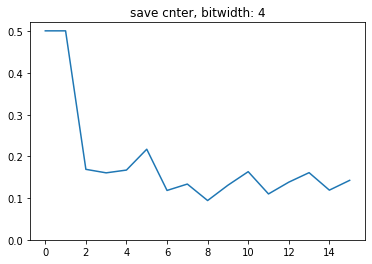

In [60]:
add_int_not_save_counter_multi(4,3)

mode: unipolar
--- 0.0010006427764892578 base seconds ---
base RMSE 0.03999158174622736
base MAE: 0.0354
Mode: unipolar
--- 0.018015623092651367 Average seconds ---
Avg RMSE 0.03959085817924023
Avg MAE: 0.03507
Avg RMSE_error from perfect: 1.00%
Avg MAE_error from perfect: 0.94%


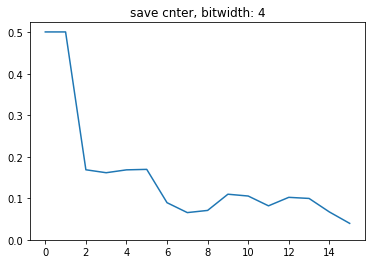

In [61]:
add_int_save_counter_multi(4,3)

mode: unipolar
--- 0.0020017623901367188 base seconds ---
base RMSE 0.04004398669224557
base MAE: 0.03555
Mode: unipolar
--- 0.019016742706298828 Average seconds ---
Avg RMSE 0.201545502944039
Avg MAE: 0.1999
Avg RMSE_error from perfect: 403.31%
Avg MAE_error from perfect: 462.39%


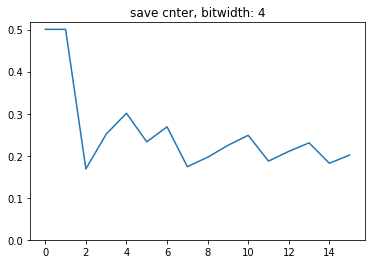

In [62]:
add_int_not_save_counter_multi(4,5)

mode: unipolar
--- 0.001001119613647461 base seconds ---
base RMSE 0.0396830753052606
base MAE: 0.0351
Mode: unipolar
--- 0.01801609992980957 Average seconds ---
Avg RMSE 0.03959069678766558
Avg MAE: 0.03499
Avg RMSE_error from perfect: 0.23%
Avg MAE_error from perfect: 0.30%


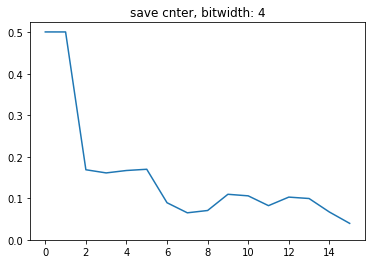

In [63]:
add_int_save_counter_multi(4,5)

mode: unipolar
--- 0.0010008811950683594 base seconds ---
base RMSE 0.018933468764144232
base MAE: 0.01665
Mode: unipolar
--- 0.019017457962036133 Average seconds ---
Avg RMSE 0.13536108935187638
Avg MAE: 0.1347
Avg RMSE_error from perfect: 614.93%
Avg MAE_error from perfect: 708.90%


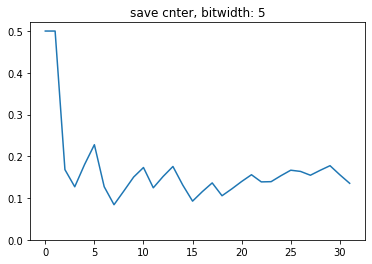

In [64]:
add_int_not_save_counter_multi(5,7)

mode: unipolar
--- 0.0010018348693847656 base seconds ---
base RMSE 0.01890161126347997
base MAE: 0.01663
Mode: unipolar
--- 0.01901721954345703 Average seconds ---
Avg RMSE 0.018821780770218108
Avg MAE: 0.01656
Avg RMSE_error from perfect: 0.42%
Avg MAE_error from perfect: 0.43%


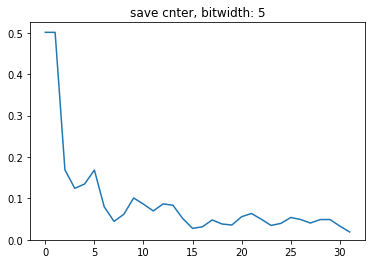

In [65]:
add_int_save_counter_multi(5,7)

mode: unipolar
--- 0.015625715255737305 base seconds ---
base RMSE 0.018824990355855185
base MAE: 0.0165
0
4
8
12
16
20
24
28
Mode: unipolar
--- 0.015625953674316406 Average seconds ---
Avg RMSE 0.1350639364271202
Avg MAE: 0.1344
Avg RMSE_error from perfect: 617.47%
Avg MAE_error from perfect: 714.48%


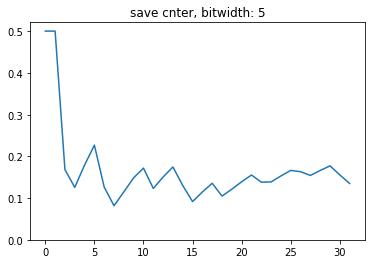

In [45]:
add_int_not_save_counter_multi(5,7)

mode: unipolar
--- 0.002001523971557617 base seconds ---
base RMSE 0.01878786190265608
base MAE: 0.01646
Mode: unipolar
--- 0.058052778244018555 Average seconds ---
Avg RMSE 0.018809988380136505
Avg MAE: 0.01649
Avg RMSE_error from perfect: 0.12%
Avg MAE_error from perfect: 0.17%


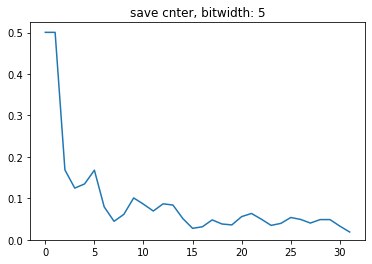

In [20]:
add_int_save_counter_multi(5,3)

mode: unipolar
--- 0.0010008811950683594 base seconds ---
base RMSE 0.018915136786562987
base MAE: 0.01662
Mode: unipolar
--- 0.01801609992980957 Average seconds ---
Avg RMSE 0.01884008731957466
Avg MAE: 0.01653
Avg RMSE_error from perfect: 0.40%
Avg MAE_error from perfect: 0.49%


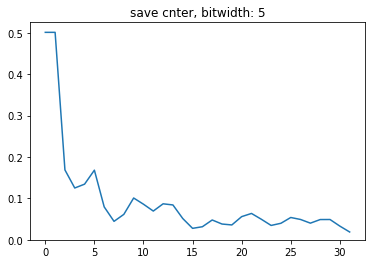

In [21]:
add_int_save_counter_multi(5,7)